In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

savedir = "models/prior-posterior"
os.makedirs(savedir, exist_ok=True)

10: loss 4.629 time 0.09


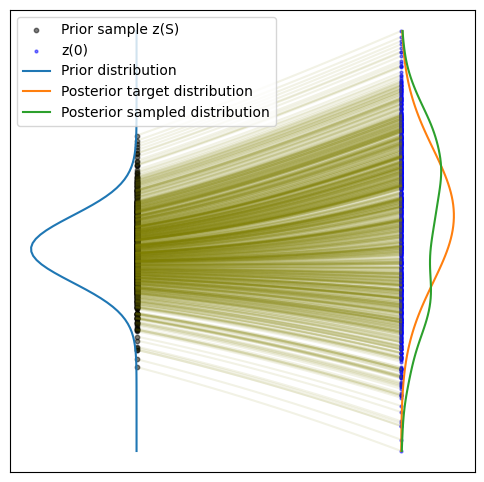

300: loss 3.171 time 9.61


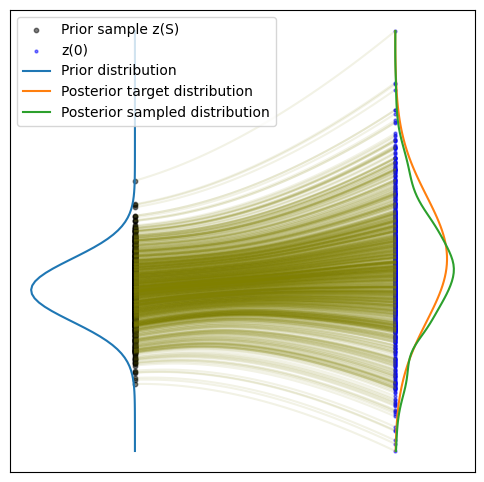

1000: loss 3.789 time 14.23


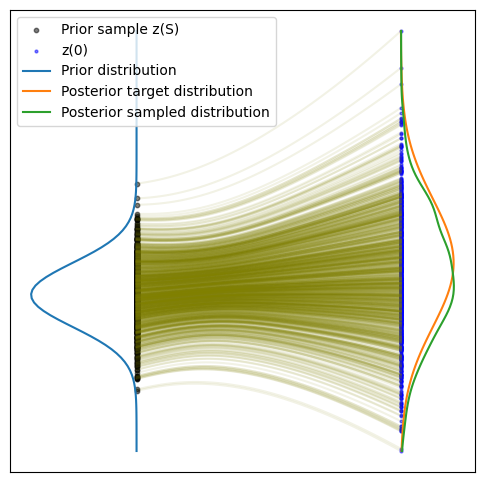

In [5]:
# %%time
sigma = 0.1
dim = 1
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)

prior = torch.distributions.Normal(loc=0.0, scale=1.0)
posterior = torch.distributions.Normal(loc=1.0, scale=2.0)

start = time.time()
for k in range(1000):
    optimizer.zero_grad()

    x0 = prior.sample((batch_size, 1))
    x1 = posterior.sample((batch_size, 1))

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    # if (k + 1) % 100 == 0:
    if (k + 1) in (10, 300, 1000):
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                prior.sample((1000, 1)),
                t_span=torch.linspace(0, 1, 100),
            )
            # traj.shape = [100, 1024, dim]
            plot_trajectories_1d(
                traj.cpu().numpy(),
                prior, posterior)

torch.save(model, f"{savedir}/cfm_v1.pt")